<a href="https://colab.research.google.com/github/MarianoChic09/MSc-AI-taller-de-deep-learning/blob/main/CNNs_2_Letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports globales y funciones de utilidad

In [2]:
import time
import torch
import itertools
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_dataloaders(train_transf, test_transf, batch_size):

  train_dataset = CIFAR10("data", train=True, download=True, transform=train_transf)
  test_dataset = CIFAR10("data", train=False, download=True, transform=test_transf)

  train_size = int(0.8 * len(train_dataset))
  valid_size = len(train_dataset) - train_size
  train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
  valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

  return train_loader, valid_loader, test_loader

# Image Augmentation

La primera parte de este laboratorio consiste en expandir un poco el modelo de LeNet para tener más parámetros y luego explorar algunas técnicas de Image Augmentation (https://pytorch.org/vision/stable/transforms.html).

El modelo a implementar es el siguiente:


![Image](https://i.ibb.co/WxGgbmL/Capture.png)


In [4]:
class CustomCNN(nn.Module):
  def __init__(self, in_channels,number_classes):
    # in_channels: int, cantidad de canales de la imagen original
    super(CustomCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels = 32, kernel_size = 3,padding=1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3,padding=1)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3,padding=1)
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3,padding=1)
    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 120, kernel_size = 3,padding=1)

    self.linear1 = nn.Linear(in_features = 120*4*4, out_features = 512)
    self.linear2 = nn.Linear(in_features = 512, out_features = number_classes)

    self.max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = self.max_pooling(out)

    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    out = self.max_pooling(out)

    out = F.relu(self.conv5(out))
    out = self.max_pooling(out)

    out = self.dropout(out.flatten(1))

    out = F.relu(self.linear1(out))
    out = self.dropout(out)
    out = self.linear2(out)
    return out

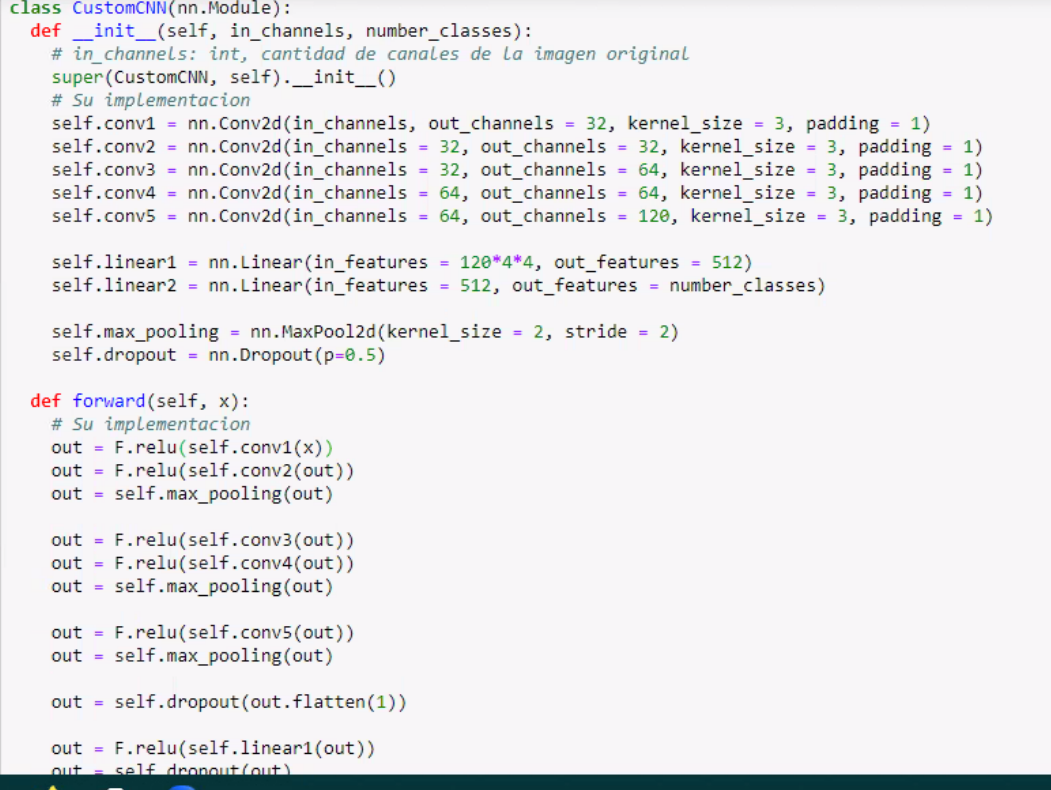

## Funciones genericas para entrenar nuestros modelos

Vamos a utilizar las mismas funciones que implementamos en los laboratorios anteriores para entrenar y testear nuestros modelos.

In [5]:
def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in loader:
      all_labels.extend(labels.numpy())

      optim.zero_grad()

      predictions = training_model(images.to(device))
      all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

      loss = criterion(predictions, labels.to(device))

      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
      for images, labels in loader:
        all_labels.extend(labels.numpy())

        predictions = val_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        loss = criterion(predictions, labels.to(device))

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def train_model(model, train_loader, test_loader, criterion, optim, number_epochs):
  train_history = []
  test_history = []
  accuracy_history = []

  for epoch in range(number_epochs):
      start_time = time.time()

      train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

      start_time = time.time()
      test_loss, acc = validation_epoch(model, test_loader, criterion)
      test_history.append(test_loss)
      accuracy_history.append(acc)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, test_loss, acc, time.time() - start_time))

## Entrenando modelos

Comenzamos definiendo una seccion de código con valores por defecto de hiperparámetros que vamos a utilizar y luego entrenamos un modelo de la CNN definida anteriormente sin usar augmentation en los datos y otro haciendo uso del mismo.

https://pytorch.org/vision/stable/transforms.html

In [6]:
# Global models config

BATCH_SIZE = 128
LR = 0.001
NUMBER_EPOCHS = 15
criterion = nn.CrossEntropyLoss().to(device)

In [7]:
# Fijamos las semillas siempre para poder comparar.

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Creamos los dataloaders
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.ToTensor()
])

train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

# Definimos el modelo y el optimizador
modelo_sin_aug = CustomCNN(3,10).to(device)
optimizer = torch.optim.Adam(modelo_sin_aug.parameters(), lr=LR)

# Entrenamos
train_model(modelo_sin_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

100%|██████████| 170498071/170498071 [00:02<00:00, 80715551.93it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Training epoch 1 | Loss 1.848839 | Accuracy 31.59% | Time 13.39 seconds
Validation epoch 1 | Loss 1.513068 | Accuracy 43.30% | Time 0.75 seconds
Training epoch 2 | Loss 1.447979 | Accuracy 46.88% | Time 4.29 seconds
Validation epoch 2 | Loss 1.244909 | Accuracy 55.19% | Time 0.83 seconds
Training epoch 3 | Loss 1.234579 | Accuracy 55.21% | Time 4.30 seconds
Validation epoch 3 | Loss 1.060388 | Accuracy 62.50% | Time 0.78 seconds
Training epoch 4 | Loss 1.106863 | Accuracy 60.36% | Time 4.35 seconds
Validation epoch 4 | Loss 0.999841 | Accuracy 65.07% | Time 0.76 seconds
Training epoch 5 | Loss 1.008458 | Accuracy 64.06% | Time 4.30 seconds
Validation epoch 5 | Loss 0.947977 | Accuracy 66.60% | Time 0.81 seconds
Training epoch 6 | Loss 0.932268 | Accuracy 66.74% | Time 4.36 seconds
Validation epoch 6 | Loss 0.868407 | Accuracy 68.95% | Time 0.80 seconds
Training epoch 7 | Loss 0.881046 | Accuracy 68.78%

In [8]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Creamos los datasets
test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Definir transormaciones que vamos a aplicar al set de entrenamiento
train_transform = transforms.Compose([
    transforms.RandomInvert(p=0.2),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.6),
    transforms.ToTensor()
])
train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)


# Definimos el modelo y el optimizador
modelo_con_aug = CustomCNN(3,10).to(device)
optimizer = torch.optim.Adam(modelo_con_aug.parameters(), lr=LR)

# Entrenamos
train_model(modelo_con_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

Files already downloaded and verified
Files already downloaded and verified
Training epoch 1 | Loss 2.055859 | Accuracy 22.11% | Time 4.47 seconds
Validation epoch 1 | Loss 1.801533 | Accuracy 32.28% | Time 1.06 seconds
Training epoch 2 | Loss 1.714370 | Accuracy 36.34% | Time 4.41 seconds
Validation epoch 2 | Loss 1.536719 | Accuracy 43.54% | Time 1.08 seconds
Training epoch 3 | Loss 1.551338 | Accuracy 42.79% | Time 4.59 seconds
Validation epoch 3 | Loss 1.464184 | Accuracy 46.69% | Time 1.17 seconds
Training epoch 4 | Loss 1.434754 | Accuracy 47.41% | Time 4.51 seconds
Validation epoch 4 | Loss 1.323241 | Accuracy 52.59% | Time 1.03 seconds
Training epoch 5 | Loss 1.341001 | Accuracy 51.42% | Time 4.52 seconds
Validation epoch 5 | Loss 1.223299 | Accuracy 55.71% | Time 1.23 seconds
Training epoch 6 | Loss 1.267614 | Accuracy 54.32% | Time 4.54 seconds
Validation epoch 6 | Loss 1.167651 | Accuracy 58.76% | Time 1.11 seconds
Training epoch 7 | Loss 1.205073 | Accuracy 56.48% | Time 4.

## Evaluando los modelos en los datos de test

Vamos a comenzar evaluando en los datos de test normales y luego vamos a aplicar distintas transformaciones (para simular entornos más reales de datos) y vamos a ver la performance y robustez de los modelos que entrenamos anteriormente.

Primero agregar horizontal flip y luego vertical flip, qué pasa con los modelos?

In [9]:
test_transform = transforms.Compose([
  transforms.ToTensor()
])

_, _, test_loader = get_dataloaders(None, test_transform, BATCH_SIZE)

# Testear usando las funciones definidas anteriormente
loss, acc = validation_epoch(modelo_con_aug, test_loader, criterion)
print('Test loss: ', loss, '- Test Acc:', acc)

Files already downloaded and verified
Files already downloaded and verified
Test loss:  0.933301264726663 - Test Acc: 66.8


In [10]:
test_transform = transforms.Compose([
  # Flip Horizontal y volver a testear
  transforms.RandomHorizontalFlip(p=0.2),
  transforms.ToTensor()
])

_, _, test_loader = get_dataloaders(None, test_transform, BATCH_SIZE)

# Testear usando las funciones definidas anteriormente
loss, acc = validation_epoch(modelo_con_aug, test_loader, criterion)
print('Test loss: ', loss, '- Test Acc:', acc)

Files already downloaded and verified
Files already downloaded and verified
Test loss:  0.9387762003307101 - Test Acc: 66.86999999999999


In [11]:
test_transform = transforms.Compose([
  # Flip Vertical y volver a testear
  transforms.RandomVerticalFlip(p=0.2),
  transforms.RandomInvert(p=0.3),
  transforms.RandomHorizontalFlip(p=0.6),
  transforms.ToTensor()
])

_, _, test_loader = get_dataloaders(None, test_transform, BATCH_SIZE)

# Testear usando las funciones definidas anteriormente
loss, acc = validation_epoch(modelo_con_aug, test_loader, criterion)
print('Test loss: ', loss, '- Test Acc:', acc)

Files already downloaded and verified
Files already downloaded and verified
Test loss:  0.9914288400094721 - Test Acc: 64.89


In [12]:
# Otros tests que quieran probar...

# DenseNet


![Image](https://miro.medium.com/max/5164/1*_Y7-f9GpV7F93siM1js0cg.jpeg)

Link al paper original: [DenseNets](https://arxiv.org/pdf/1608.06993.pdf)

Algunas consideraciones del paper a tener en cuenta:

1. Batch normalization en los inputs de los bloques densos y las capas de transición.
2. ReLU en todos lados como funcion de activación.
3. El MLP al final de la red cuenta con una capa oculta de 512 neuronas
4. Las activaciones luego del tercer bloque denso tienen tamaño 4*4 (ejercicio, calcular a mano!)


Implementamos DenseNet para resolver el problema de CIFAR10


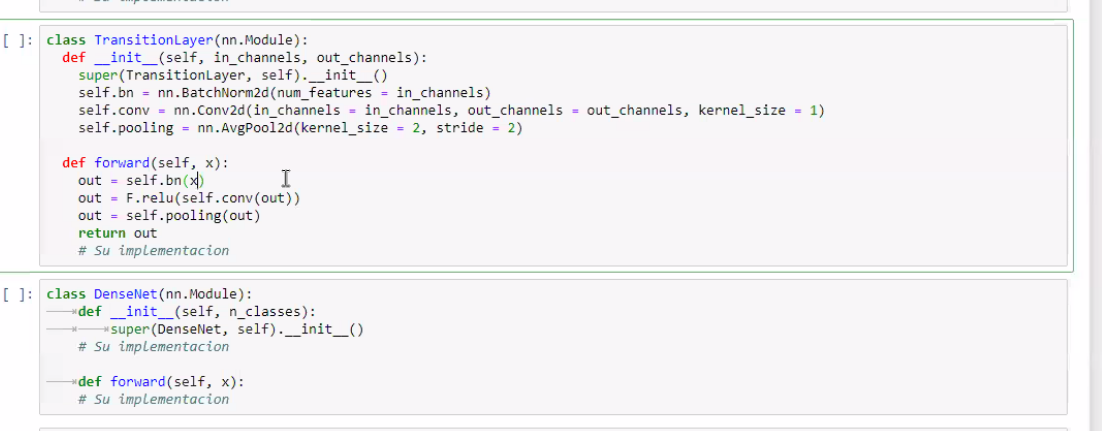

In [14]:
class CompositeFunction(nn.Module):
  # BatchNorm + Relu + Conv
  def __init__(self, in_channels, out_channels, kernel_size,input_shape,strides):
    super(CompositeFunction, self).__init__()
    self.bn = nn.BatchNorm2d(num_features = in_channels)
    # P = int(kernel_size/2)
    P = int((input_shape*strides-input_shape-strides+kernel_size)/2)
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = "same") # o padding = 1

  def forward(self,x):
    out = self.bn(x)
    out = self.conv(F.relu(out))
    return out

In [ ]:
class DenseBlock(nn.Module):
  def __init__(self, in_channels, reps, k):
    super(DenseBlock, self).__init__()
    self.reps = reps
    self.convs = []
    for i in range(reps):
      self.convs.append(CompositeFunction(in_channels+k*i, 4*k, 1))
      self.convs.append(CompositeFunction(10, k, 3))
    self.convs = nn.ModuleList(self.convs)
  def forward(self, x):
    for i in range(self.reps):
      x1 = self.convs[2*i](x)
      x2 = self.convs[2*i+1](x1)
      x = torch.cat([x,x2],1)
    return x
    # Su implementacion

In [ ]:
class TransitionLayer(nn.Module):
  # out_channels = in_channels + k* reps
  # bottleneck = 4*k
  def __init__(self, in_channels, out_channels):
    super(TransitionLayer, self).__init__()
    # self.bn = nn.BatchNorm2d(num_features = in_channels)
    # self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1)
    self.comp = CompositeFunction(in_channels, out_channels, 1)
    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
    # Su implementacion

  def forward(self, x):
    out = self.comp(x)
    out = self.pool(out)
    return out


In [ ]:
class DenseNet(nn.Module):
	def __init__(self, n_classes):
		super(DenseNet, self).__init__()
		self.input_conv = CompositeFunction(in_channels = 3, out_channels = 2*k, 7, input_shape, stride)
		self.input_max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)


	def forward(self, x):
    # Su implementacion

In [ ]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Creamos los datasets
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

densenet = DenseNet(10).to(device)
optimizer = torch.optim.Adam(densenet.parameters(), lr=LR)

train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

train_model(densenet, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

In [ ]:
test_transform = transforms.Compose([
  transforms.ToTensor()
])

_, _, test_loader = get_dataloaders(None, test_transform, BATCH_SIZE)

test_loss, accuracy = validation_epoch(densenet, test_loader, criterion)
print(f"DenseNet Test set: {test_loss:.6f} Loss. Accuracy {accuracy:.2f}%")